In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

#векторный формат
%config InlineBackend.figure_format = 'svg'

## 1. Прогружаем данные

In [10]:
table = pd.read_csv('Data/BTC_Kraken.csv', index_col='Date', parse_dates=True)
ETH = pd.read_csv('Data/ETH_Bitfinex.csv', index_col='Date', parse_dates=True)
LTC = pd.read_csv('Data/LTC_Bitfinex.csv', index_col='Date', parse_dates=True)

In [11]:
print(len(ETH))
print(len(LTC))
print(len(table))

1229
1229
1228


In [12]:
table['BTC'] = table['Price']
table['ETH'] = ETH['Price']
table['LTC'] = LTC['Price']

In [13]:
del table['Price']
del table['Open']
del table['High']
del table['Low']
del table['Vol.']
del table['Change %']
#del table['BTC']

In [14]:
#table.drop(table.tail(9).index, inplace=True)
#LTC.drop(LTC.tail(len(LTC) - len(ETH)).index,inplace=True)

In [15]:
table['BTC'] = table['BTC'].str.replace(',', '').astype(float)
table['ETH'] = table['ETH'].str.replace(',', '').astype(float)
table['LTC'] = table['LTC'].astype(float)

In [16]:
#сделаем инверсию таблицы с котировками
table = table[-1:1:-1]

## 2. Смотрим динамику курса

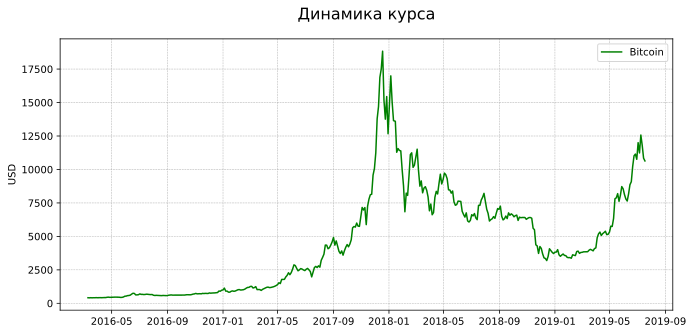

In [17]:
figure(figsize=(11,5))
plt.plot(table['BTC'][0::3], color='green', marker='', linestyle='-', markerfacecolor='blue', label = 'Bitcoin');
plt.grid(linestyle='--', linewidth=0.5)

#plt.legend(loc='upper center', ncol=2);
plt.legend(loc='best');        

#Подписи для осей:
#plt.xlabel('time', fontsize=10)
plt.ylabel('USD', fontsize=10);

#Диапазон осей:
#plt.xlim('2016-03-14', '2019-08-01');
#plt.ylim(0, 3000);

# Градуировка осей
#plt.yticks(range(0, 3200, 500), fontsize=12)

#Заголовок:
plt.title('Динамика курса', fontsize=16, y=1.05);

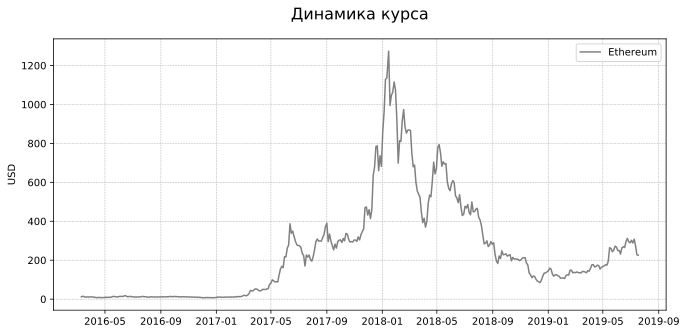

In [18]:
figure(figsize=(11,5))
plt.plot(table['ETH'][0::3], color='grey', marker='', linestyle='-', markerfacecolor='blue', label = 'Ethereum');
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(loc='best');        
plt.ylabel('USD', fontsize=10);
plt.title('Динамика курса', fontsize=16, y=1.05);

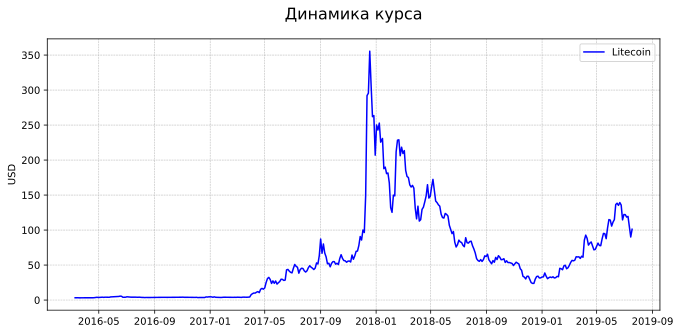

In [19]:
figure(figsize=(11,5))
plt.plot(table['LTC'][0::3], color='blue', marker='', linestyle='-', markerfacecolor='blue', label = 'Litecoin');
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(loc='best');        
plt.ylabel('USD', fontsize=10);
plt.title('Динамика курса', fontsize=16, y=1.05);

## 3. Взаимная корреляция

In [20]:
table.corr()

,BTC,ETH,LTC
BTC,1.000000,0.841353,0.930859
ETH,0.841353,1.000000,0.905310
LTC,0.930859,0.905310,1.000000


## 4. Доходность каждого из активов

Доходность (Rate of Return) – это относительный прирост стоимости актива в каждом из периодов по отношению к предыдущему значению:
$$
ROR(t_i) = \frac{Close(t_i)}{Close(t_{i-1})} - 1 , \ i = 1,\ldots,n
$$

In [21]:
close = table['ETH'][::30].values.copy()
ror = np.diff(close) / close[:-1]

In [22]:
aror = (ror + 1.).cumprod() - 1.

In [23]:
years_total = aror.size / 12
cagr = ((aror[-1] + 1.)/(aror[0] + 1.)) ** (1 / years_total) - 1.
print('Среднегодовая доходность = ', round(cagr*100, 2),'%')

Среднегодовая доходность =  188.2 %


## 5. Построение границы эффективности

In [24]:
selected = ['BTC', 'ETH', 'LTC']

In [40]:
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250

In [41]:
# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

In [42]:
# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

In [43]:
# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 9000

In [44]:
#set random seed for reproduction's sake
np.random.seed(101)

In [45]:
# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

In [46]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

In [47]:
# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

In [48]:
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

In [49]:
# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]

In [50]:
# reorder dataframe columns
df = df[column_order]

In [51]:
df.tail()

,Returns,Volatility,Sharpe Ratio,BTC Weight,ETH Weight,LTC Weight
8995,1.026292,0.721901,1.421651,0.454096,0.129824,0.416081
8996,1.022159,0.775336,1.318343,0.274659,0.627252,0.098089
8997,1.097247,0.810446,1.353880,0.151922,0.320222,0.527856
8998,1.117403,0.852336,1.310989,0.127910,0.214742,0.657348
8999,0.996648,0.684775,1.455439,0.535406,0.166239,0.298356


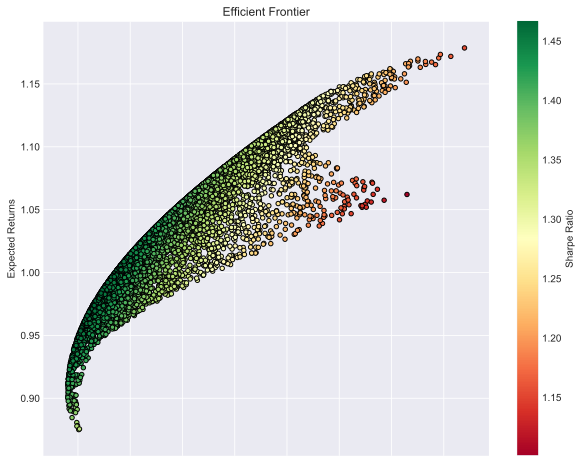

In [52]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

## 6. Оптимальное соотношение активов

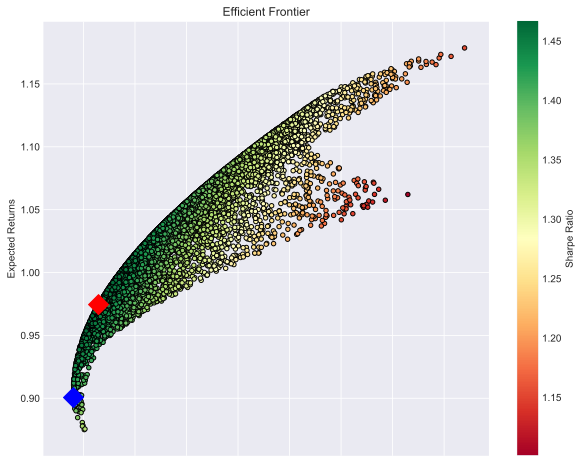

In [53]:
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [54]:
# print the details of the 2 special portfolios
print(min_variance_port.T)
print(sharpe_portfolio.T)

                  7657
Returns       0.900596
Volatility    0.640304
Sharpe Ratio  1.406513
BTC Weight    0.855082
ETH Weight    0.139166
LTC Weight    0.005752
                  7012
Returns       0.974513
Volatility    0.664613
Sharpe Ratio  1.466287
BTC Weight    0.589927
ETH Weight    0.209419
LTC Weight    0.200654
